# Library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import xgboost
import sklearn

from sklearn.svm import SVC
from xgboost import plot_importance
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from numpy import std

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils import resample

import scipy as sc

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import seaborn as sns

sns.set_palette(sns.color_palette())

In [4]:
df = pd.read_excel('/content/drive/My Drive/Colab_Notebooks/covid_detect_clean.xlsx')

In [5]:
imp_mean = IterativeImputer(random_state=0, max_iter=10000)
df_iter = imp_mean.fit_transform(df.iloc[:,1:-1].values)
df_target = df.iloc[:,-1].values

# XGB

In [6]:
# grid search for XGB
param_grid_xgb = [{'n_estimators' : [5,10,15,20,25,30,35,40,45,50]}]

xgb_gs = GridSearchCV(xgboost.XGBClassifier(random_state=0), param_grid_xgb, cv=5, n_jobs=-1)

xgb_gs.fit(df_iter, df_target)

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid=[{'n_estimators': [5, 10, 15, 20, 25, 30, 35, 40, 45,
                                           50]}],
             pre_dispatch='2*n_jobs', refit=True, r

In [9]:
def fi(x):
    plt.style.use('seaborn')
    feature_list = ['AGE', 'WBC', 'Piastrine', 'Neutrofili', 'Linfociti', 'Monociti',
             'Eosinofili', 'Basofili', 'PCR', 'AST', 'ALT', 'ALP', 'GGT', 'LDH']
    df_fi = pd.DataFrame(columns=['features', 'importance'])
    df_fi['importance'] = x
    df_fi['features'] = feature_list
    df_fi = df_fi.sort_values('importance', ascending=True)  
    plt.barh(range(len(df_fi)), df_fi['importance'], tick_label = df_fi['features'])
    plt.show()

## Feature Importance

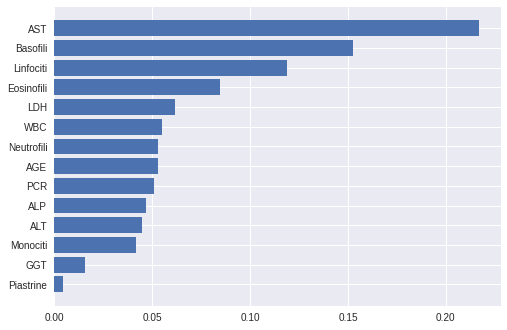

In [10]:
xgb_fi = xgb_gs.best_estimator_.feature_importances_
fi(xgb_fi)

## Recursive Feature Elimination

In [ ]:
# Recursive Feature Elimination
from yellowbrick.features import RFECV

def y_elimination(x):
  viz = RFECV(x)
  viz.fit(df_iter, df_target)
  viz.poof()
  

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


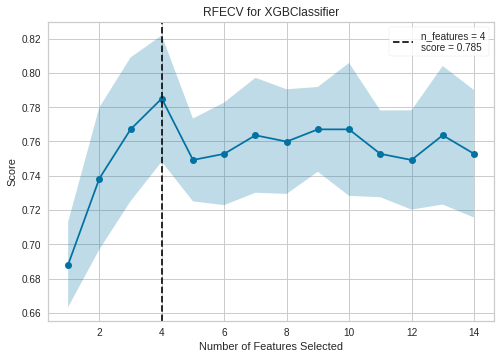

In [ ]:
y_elimination(xgboost.XGBClassifier(random_state=0))

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html#sklearn.feature_selection.RFECV
from sklearn.feature_selection import RFECV

def elimination(x, n):
  rfecv = RFECV(estimator=x, step=1, cv=5,
                scoring='accuracy',
                min_features_to_select=n)

  rfecv.fit(df_iter, df_target)

  print("Optimal number of features : %d" % rfecv.n_features_)

  plt.figure()
  plt.xlabel("Number of features selected")
  plt.ylabel("Cross validation score (nb of correct classifications)")
  plt.plot(range(n,len(rfecv.grid_scores_) + n),rfecv.grid_scores_)
  plt.show()
  return rfecv.support_

Optimal number of features : 4


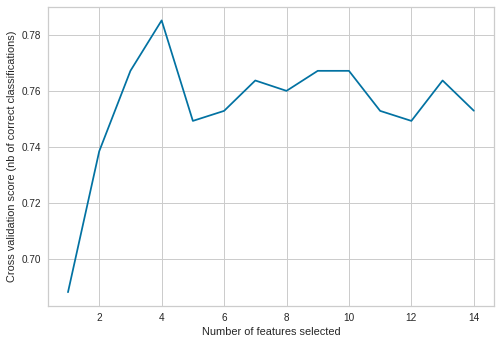

Index(['AGE', 'Linfociti', 'Basofili', 'AST'], dtype='object')

In [ ]:
df.columns[1:-1][elimination(xgboost.XGBClassifier(random_state=0), 1)]

## Discrimination Threshold

In [ ]:
from yellowbrick.classifier import DiscriminationThreshold

def d_threshold(x):
  viz = DiscriminationThreshold(x)
  viz.fit(df_iter, df_target)  
  viz.poof()

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


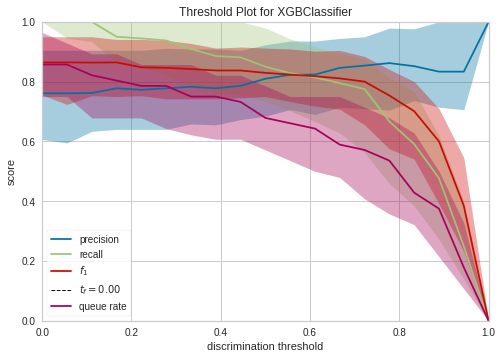

In [ ]:
d_threshold(xgboost.XGBClassifier(random_state=0))

# RF

In [11]:
# grid search for RF
param_grid_rf = [{'n_estimators' : [25, 50, 100, 150, 200]}]

rf_gs = GridSearchCV(RandomForestClassifier(random_state=0), param_grid_rf, cv=5, n_jobs=-1)

rf_gs.fit(df_iter, df_target)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=0,
                                   

## Feature Importance

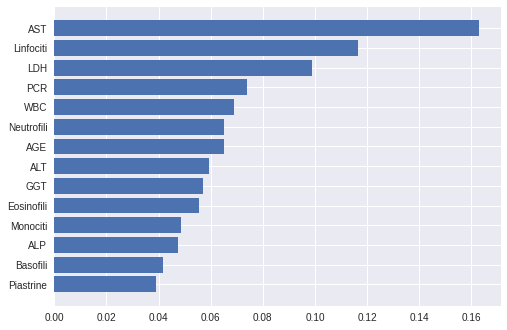

In [12]:
rf_fi = rf_gs.best_estimator_.feature_importances_    
fi(rf_fi)

## Recursive Feature Elimination

In [ ]:
y_elimination(RandomForestClassifier(random_state=0))

AttributeError: ignored

Optimal number of features : 12


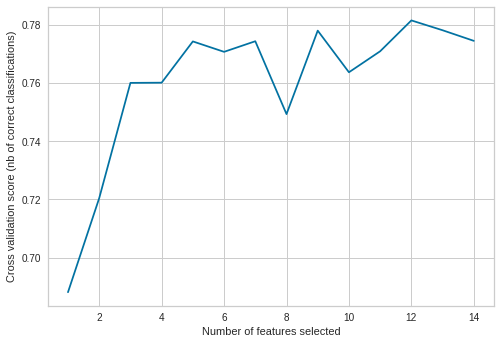

array([ True,  True, False,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True])

In [ ]:
elimination(RandomForestClassifier(random_state=0), 1)

## Discrimination Threshold

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/u

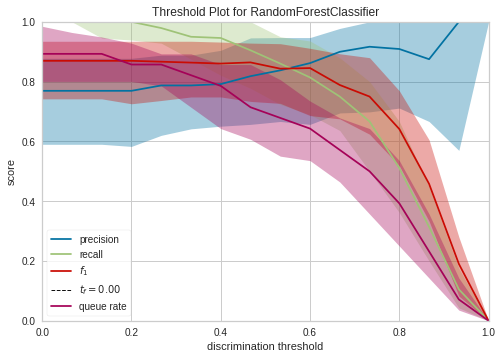

In [ ]:
d_threshold(RandomForestClassifier(random_state=0))

# DT

In [ ]:
# grid search for DT
param_grid_dt = {'max_depth' : [2, 3, 4, 5, 6]}

dt_gs = GridSearchCV(DecisionTreeClassifier(random_state=0), param_grid_dt, cv=5)

dt_gs.fit(df_iter, df_target)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=0, splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [2, 3, 4, 5, 6]}, pre_dispatch='2*n_jobs',
             refit=True, return_train_score=Fa

## Feature Importance

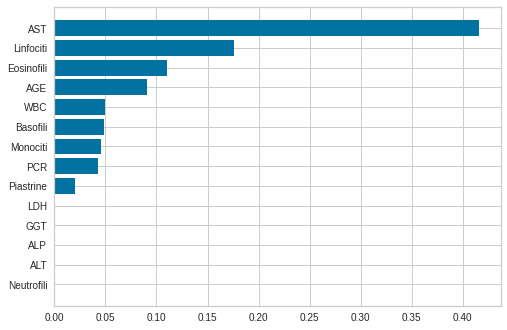

In [ ]:
dt_fi = dt_gs.best_estimator_.feature_importances_    
fi(dt_fi)

## Recursive Feature Elimination

In [ ]:
y_elimination(DecisionTreeClassifier(random_state=0))

AttributeError: ignored

Optimal number of features : 6


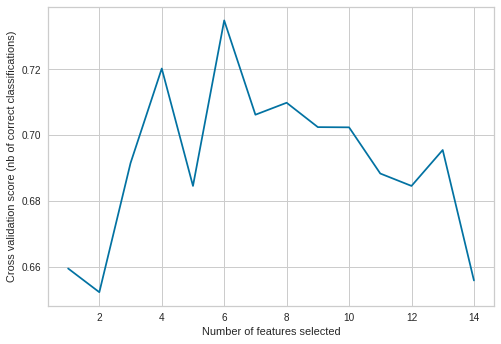

array([ True, False, False, False,  True,  True, False, False, False,
        True,  True, False, False,  True])

In [ ]:
elimination(DecisionTreeClassifier(random_state=0), 1)

## Discrimination Threshold

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/u

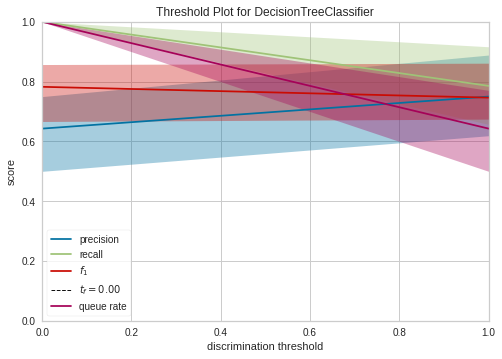

In [ ]:
d_threshold(DecisionTreeClassifier(random_state=0))

# Light GBM

In [13]:
import lightgbm as lgb
# grid search for lgb
param_grid_lgb = [{'n_estimators' : range(50, 200, 25), 
           'max_depth' : [3, 4, 5, 6, 7]}]   

lgb_gs = GridSearchCV(lgb.LGBMClassifier(random_state=0), param_grid_lgb, cv=5)

lgb_gs.fit(df_iter, df_target)

GridSearchCV(cv=5, error_score=nan,
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31, objective=None,
                                      random_state=0, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=True,
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='deprecated', n_jobs=None,
             param_grid=[{'max_depth': [3, 4, 5, 6, 7],
                          'n_estimators':

## Feature Importance

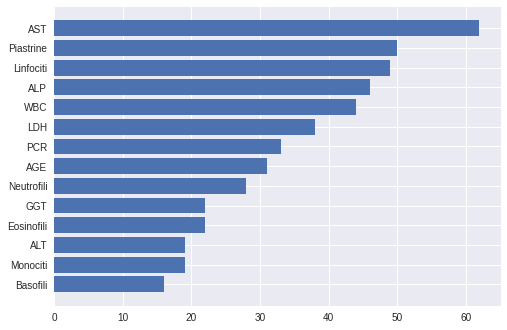

In [14]:
lgb_fi = lgb_gs.best_estimator_.feature_importances_    
fi(lgb_fi)

## Recursive Feature Elimination

In [ ]:
y_elimination(lgb.LGBMClassifier(random_state=0))

AttributeError: ignored

## Discrimination Threshold

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/u

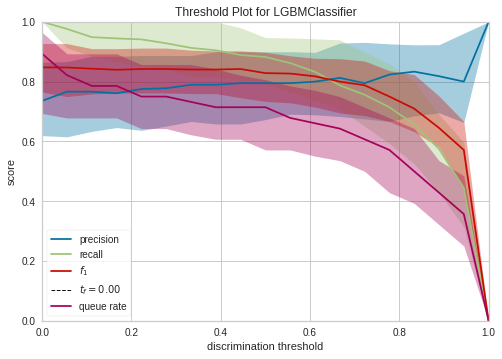

In [ ]:
d_threshold(lgb.LGBMClassifier(random_state=0))

# General

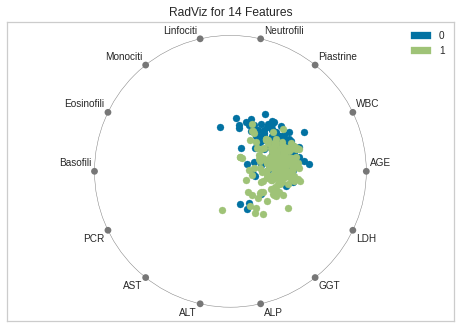

In [ ]:
from yellowbrick.features import RadViz

features = df.columns[1:-1]
classes = ["0", "1"]

visualizer = RadViz(classes=classes, features=features)

visualizer.fit(df_iter, df_target)      
visualizer.transform(df_iter)           
visualizer.poof()                       

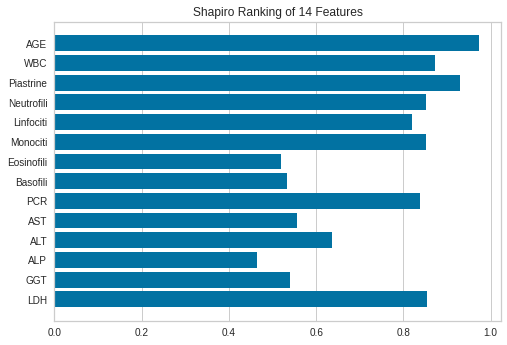

In [ ]:
from yellowbrick.features import Rank1D

visualizer = Rank1D(features=features, algorithm='shapiro')

visualizer.fit(df_iter, df_target)
visualizer.transform(df_iter)
visualizer.poof()  

# XGB/w 4 features

## Preparation

In [ ]:
pg_lr = [{'C' : [0.1, 1], 
        'max_iter' : [1000000]}]
lr    = LogisticRegression(random_state=0, max_iter = 1000)

pg_svc = [{'C' : [1, 2, 3, 4, 10],
           'kernel' : ['rbf']}]
svc = SVC(random_state=0)


pg_dt = [{'max_depth' : [1, 2, 3, 4, 5, 6]}]

dt = DecisionTreeClassifier(random_state=0)


pg_rf = [{'n_estimators' : [25, 50, 100, 150, 200], 
            'max_depth' : [5, 6, 7, 8, 9],
            'max_leaf_nodes' : [20,22,24,26,28]}]

rf = RandomForestClassifier(random_state=0)

pg_xgb = [{'n_estimators' : [25, 30, 50, 70, 100, 150], 
            'max_depth' : [3, 4, 5, 6, 7]}]

xgb = xgboost.XGBClassifier(random_state=0)

pg_lgb = [{'n_estimators' : range(50, 200, 25), 
           'max_depth' : [3, 4, 5, 6, 7]}]           

import lightgbm
lgb = lightgbm.LGBMClassifier(random_state=0)    

In [ ]:
list_imp = ['mean', 'median', 'knn', 'iter', 'without']
list_model = ['LogReg', 'SVC', 'DT', 'RF', 'XGB']
dic_model = {'LogReg':lr,'SVC':svc, 'DT':dt, 'RF':rf, 'XGB':xgb  }
dic_pg    = {'LogReg':pg_lr,'SVC':pg_svc, 'DT':pg_dt, 'RF':pg_rf, 'XGB':pg_xgb  }
dic_imp = {'mean':SimpleImputer(missing_values=np.nan, strategy='mean'),
           'median':SimpleImputer(missing_values=np.nan, strategy='median'),
           'knn':  KNNImputer(n_neighbors=5, weights="uniform"),
           'iter':IterativeImputer(random_state=0, max_iter = 10000)}

## Boostrap

In [ ]:
df_four = pd.DataFrame(df, columns=['AGE', 'Linfociti', 'Basofili', 'AST', 'TARGET'])
df_four.head()

,AGE,Linfociti,Basofili,AST,TARGET
0,42,1.5,0.0,27.0,0
1,58,0.6,0.0,25.0,1
2,65,NaN,NaN,57.0,1
3,77,NaN,NaN,36.0,0
4,46,1.3,0.0,55.0,1


In [ ]:
df_0 = df_four[df_four['TARGET']==0]
df_1 = df_four[df_four['TARGET']==1]

# 177 randomly sampled in df_0, replace=ture means that sampling can be repeated
df_0_ext = df_0.sample(len(df_1), replace=True)
print(df_0_ext.shape)
print(df_1.shape)

# The concat function is a method under pandas, which can simply fuse data according to different axes
df_ext = pd.concat( [df_0_ext, df_1]  )
# drop: Simply reset the index, without inserting it as a column in a new DataFrame.
df_ext.reset_index(drop=True, inplace=True)
print(df_ext.head())

(177, 5)
(177, 5)
   AGE  Linfociti  Basofili    AST  TARGET
0   91        0.5       0.1  307.0       0
1   44        1.6       0.0   49.0       0
2   64        NaN       NaN  247.0       0
3   85        NaN       NaN   31.0       0
4   87        3.3       0.1   32.0       0


In [ ]:
df_result = pd.DataFrame(columns=list_model, index=list_imp)
ci_result = pd.DataFrame(columns=list_model, index=list_imp)
df_score  = pd.DataFrame()

In [ ]:
sss = StratifiedShuffleSplit(n_splits= 5, test_size=0.2, train_size=0.8, random_state=0)

X = df_ext.iloc[:,:-1].values
y = df_ext.iloc[:,-1].values

for model in (list_model[-1:]): # XGB
    for imputer in (list_imp[2:]): # knn & iter & without
        print(model,imputer)
        scores=[]
        for i in range(20): 
            print(i)
            # from 2nd row to the end
            X_0 = resample(df_0, replace=True, n_samples=150).iloc[:,1:]
            X_1 = resample(df_1, replace=True, n_samples=150).iloc[:,1:]
            _ = pd.concat([X_0, X_1])
            _.reset_index(drop=True, inplace=True)
            # from beginning to 2nd to last
            X = _.iloc[:,:-1].values
            y = _.iloc[:,-1].values
            for train_index, test_index in sss.split(X,y):
                if imputer != 'without':
                    X_train, X_test = X[train_index], X[test_index]
                    y_train, y_test = y[train_index], y[test_index]
                    imp = dic_imp[imputer].fit(X_train)
                    X_train = imp.transform(X_train)
                    X_test  = imp.transform(X_test)
                    grid_search = GridSearchCV(dic_model[model], dic_pg[model], cv=5)
                    grid_search.fit(X_train, y_train)
                    scores.append(grid_search.score(X_test, y_test))
                if imputer == 'without' and model == 'XGB': 
                    X_train, X_test = X[train_index], X[test_index]
                    y_train, y_test = y[train_index], y[test_index]
                    grid_search = GridSearchCV(dic_model[model], dic_pg[model], cv=5)
                    grid_search.fit(X_train, y_train)
                    scores.append(grid_search.score(X_test, y_test))
        try:
          df_result.loc[imputer,model] = sum(scores)/len(scores)
          df_score[imputer+' '+model] = scores
        except:
          pass

XGB knn
0
1


KeyboardInterrupt: ignored

## C.I

In [ ]:
df_score.to_excel("/content/drive/MyDrive/Colab_Notebooks/boostrap_score_20_4features.xlsx", index=False)
df_result.to_excel("/content/drive/MyDrive/Colab_Notebooks/boostrap_result_20_4features.xlsx")

In [ ]:
df_score.head()

""


In [ ]:
df_result

In [ ]:
df_ci = pd.DataFrame(columns=['Model_Imput', 'CI_left', 'CI_right'])
s = 0
for i in df_score.columns:
  scores = df_score[i].values
  mean = scores.mean()
  std = scores.std()
  ci = np.array([sc.stats.t.interval(0.95, len(scores), mean, std)])
  df_ci.loc[s] = [i,ci[0][0],ci[0][1]]
  s+=1
df_ci

In [ ]:
df_ci_20 = df_ci

plt.figure(figsize=(5,5))
for i in range(len(df_ci_20)):
  plt.plot([df_ci_20.iloc[i,1],df_ci_20.iloc[i,2]],[i+1,i+1], c='k')
  plt.scatter(df_ci_20.iloc[i,1], i+1, c='r')
  plt.scatter(df_ci_20.iloc[i,2], i+1, c='r')
plt.yticks(range(1,len(df_ci_20)+1), df_ci_20['Model_Imput'])
plt.grid();

## Grid Search XGB

In [ ]:
def results(model):
    print("Best parameters:\n{}".format(model.best_params_))
    print("\nBest cross-validation score:\n{:.4f}".format(model.best_score_))
    print("\nBest estimator:\n{}\n".format(model.best_estimator_))

In [ ]:
def one_param_graph(model, name):
    x = pd.DataFrame(model.cv_results_)[name]
    y = pd.DataFrame(model.cv_results_)['mean_test_score']
    plt.subplot(1, 2, 1)
    plt.plot(x, y, "b-", label='Accuracy')
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.title(name)

In [ ]:
df_four.shape

In [ ]:
# grid search for XGB
param_grid_xgb = [{'n_estimators' : [25, 30, 50, 100, 150], 
                   'max_depth' : [4, 5, 6, 7],
                   'learning_rate' : [0.2, 0.23, 0.25, 0.35],
                   'alpha': [1],
                   'subsample' : [0.8, 0.9],
                   'colsample_bytree' : [0.8, 0.9]}]

xgb_gs = GridSearchCV(xgboost.XGBClassifier(random_state=0), param_grid_xgb, cv=5, n_jobs=-1)

X_train, X_test, y_train, y_test = train_test_split(X, y)

xgb_gs.fit(X_train, y_train)

print("\nTest score:\n{}\n".format(xgb_gs.score(X_test, y_test)))

results(xgb_gs)

confusion = confusion_matrix(y_test, xgb_gs.predict(X_test))
print("Confusion matrix:\n{}".format(confusion))

# only need to change the second attribute to get the graph
# every hyperparam must start with "param_"
# one_param_graph(xgb_gs, 'param_n_estimators')


Test score:
0.8933333333333333



NameError: ignored

# Result of 4 features

In [ ]:
df_score = pd.read_excel("/content/drive/MyDrive/Colab_Notebooks/boostrap_score_20_4features.xlsx")
df_result = pd.read_excel("/content/drive/MyDrive/Colab_Notebooks/boostrap_result_20_4features.xlsx")

In [ ]:
df_ci = pd.DataFrame(columns=['Model_Imput', 'CI_left', 'CI_right'])
s = 0
for i in df_score.columns:
  scores = df_score[i].values
  mean = scores.mean()
  std = scores.std()
  ci = np.array([sc.stats.t.interval(0.95, len(scores), mean, std)])
  df_ci.loc[s] = [i,ci[0][0],ci[0][1]]
  s+=1
df_ci

,Model_Imput,CI_left,CI_right
0,knn XGB,0.711603,0.931397
1,iter XGB,0.742243,0.933423
2,without XGB,0.728800,0.928533


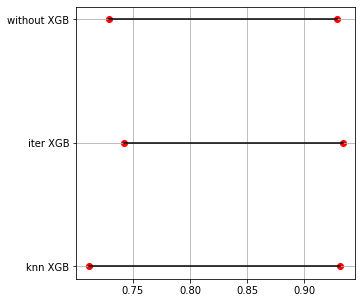

In [ ]:
df_ci_20 = df_ci

plt.figure(figsize=(5,5))
for i in range(len(df_ci_20)):
  plt.plot([df_ci_20.iloc[i,1],df_ci_20.iloc[i,2]],[i+1,i+1], c='k')
  plt.scatter(df_ci_20.iloc[i,1], i+1, c='r')
  plt.scatter(df_ci_20.iloc[i,2], i+1, c='r')
plt.yticks(range(1,len(df_ci_20)+1), df_ci_20['Model_Imput'])
plt.grid();